In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
import joblib
import pickle
import math
import ast
from scipy.stats import median_abs_deviation, hypergeom, mannwhitneyu
from scipy.cluster.hierarchy import linkage, dendrogram, leaves_list
from scipy.spatial.distance import pdist, squareform

In [2]:
# Define file paths 
output_folder = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/output/figures'
data_folder = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/output'
input_folder = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/output/intermediate_tmp_files'

## Plot cell state distributions per fate

In [3]:
# load cell_count_per_window_df from csv file
cell_count_per_window_df = pd.read_csv(os.path.join(input_folder, 'cell_count_per_window_df.csv'), header=0, index_col=0)
day_count_per_window_df = pd.read_csv(os.path.join(input_folder, 'day_count_per_window_df.csv'), header=0, index_col=0)
pseudotime_values_of_windows = pd.read_csv(os.path.join(input_folder, 'pseudotime_values_of_windows.csv'), header=None)[0].tolist()
cell_count_per_window_df.columns = cell_count_per_window_df.columns.astype(int)
day_count_per_window_df.columns = day_count_per_window_df.columns.astype(int)

In [4]:
# assign window indices to bifurcation branches
PB_fate_window_indices = [1] + list(range(97, 3, -1)) + [0] + list(range(98, 147, 1)) + [2]
GC_fate_window_indices = [1] + list(range(97, 3, -1)) + [0] + list(range(147, 193, 1)) + [3]
PB_post_bifurcation_window_indices = [0] + list(range(98, 147, 1)) + [2]
GC_post_bifurcation_window_indices = [0] + list(range(147, 193, 1)) + [3]

# Define distinct colors for better visibility
colors_cell_count = {
    'ActB-1': '#87CEFA',     # lightskyblue
    'ActB-2': '#1E90FF',     # dodgerblue
    'ActB-3': '#00008B',     # darkblue
    'ActB-4': '#9370DB',     # mediumorchid
    'GC-1': '#7BDE7B',       # custom light green
    'GC-2': '#008000',       # green
    'PB-2': '#BB3636',       # custom red
    'earlyActB': '#008080',   # teal
    'earlyPB': '#F08080'   # lightcoral
}
colors_day_count = {
    'day0_2': '#87CEFA',     # lightskyblue
    'day3_4': '#1E90FF',     # dodgerblue
    'day5_6': '#00008B'
}

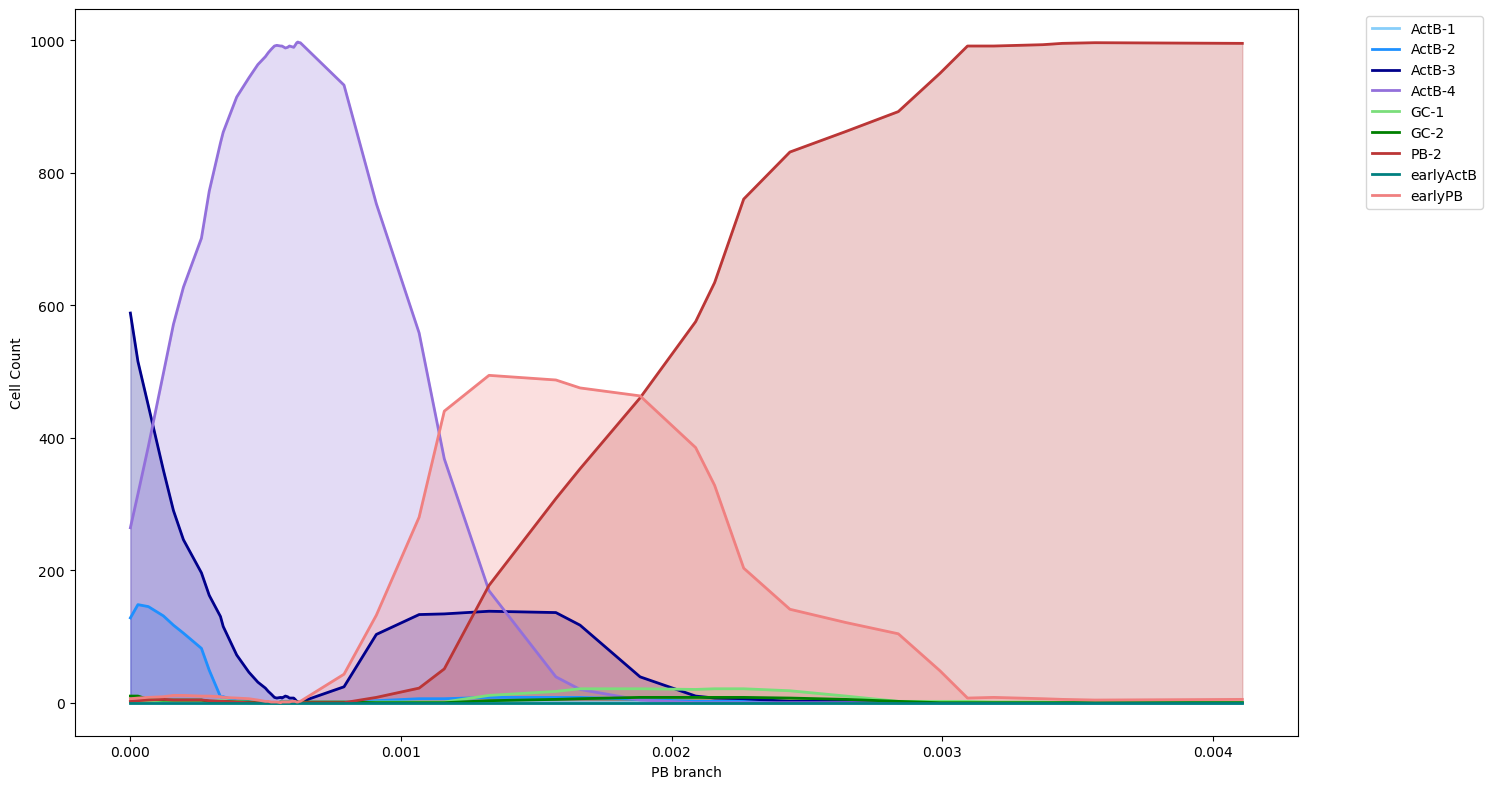

In [15]:
# Create a new dataframe with only the columns in PB_fate_window_indices
df_plot = cell_count_per_window_df[PB_post_bifurcation_window_indices]

# Plot
plt.figure(figsize=(15, 8))
plt.style.use('default')
plt.grid(False)

# Create x-axis positions
x = [pseudotime_values_of_windows[i] for i in PB_post_bifurcation_window_indices]

for state in df_plot.index:
    y = df_plot.loc[state]
    line = plt.plot(x, y,
                    label=state,
                    color=colors_cell_count[state],
                    linewidth=2)
    # shade under curve
    plt.fill_between(x, y,
                     color=colors_cell_count[state],
                     alpha=0.25)      # adjust alpha for desired lightness

plt.xlabel('PB branch')
plt.ylabel('Cell Count')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
# plt.savefig('/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/output/figures/day_count_per_window_PB.pdf', 
#             bbox_inches='tight', 
#             dpi=100,
#             format='pdf')
plt.show()

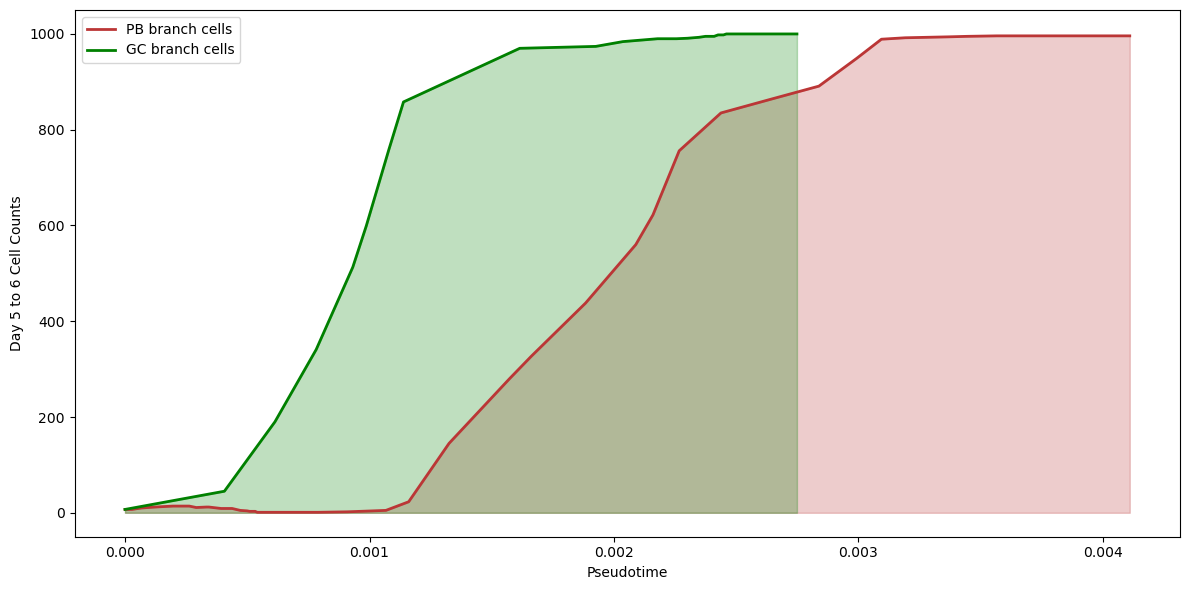

In [13]:
import matplotlib.pyplot as plt

# Extract the day5_6 data for PB and GC windows
pb_indices = PB_post_bifurcation_window_indices
gc_indices = GC_post_bifurcation_window_indices

pb_pseudotime = [pseudotime_values_of_windows[i] for i in pb_indices]
gc_pseudotime = [pseudotime_values_of_windows[i] for i in gc_indices]

pb_day5_6 = day_count_per_window_df.loc['day5_6', pb_indices]
gc_day5_6 = day_count_per_window_df.loc['day5_6', gc_indices]

plt.figure(figsize=(12, 6))

# Plot PB branch
plt.plot(pb_pseudotime, pb_day5_6, label='PB branch cells', color='#BB3636', linewidth=2)
plt.fill_between(pb_pseudotime, pb_day5_6, color='#BB3636', alpha=0.25)

# Plot GC branch
plt.plot(gc_pseudotime, gc_day5_6, label='GC branch cells', color='#008000', linewidth=2)
plt.fill_between(gc_pseudotime, gc_day5_6, color='#008000', alpha=0.25)

plt.xlabel('Pseudotime')
plt.ylabel('Day 5 to 6 Cell Counts')
plt.legend()
plt.tight_layout()
plt.show()

# Enriched regulons from static GRN analysis and plotting

In [3]:
dictys_dynamic_object = dictys.net.dynamic_network.from_file(os.path.join(data_folder, 'dynamic.h5'))

#### Load enriched link as per state

In [4]:
#Red = PB, Blue = GC
state_LF_file = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/other_files/LF_enriched_TFs_static_GRN/gene_colors.csv'
enriched_links_file = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/other_files/LF_enriched_TFs_static_GRN/SLIDE_LF_enrichment/SLIDE_LF_enriched_1_TFs_7_3_GC_PB.csv'
# store the state_LF in a df
state_LF = pd.read_csv(state_LF_file)
enriched_links = pd.read_csv(enriched_links_file)

In [5]:
def create_enriched_links_per_state(enriched_links, state_LF):
    # Create dictionaries to map genes to their states
    gene_to_state = dict(zip(state_LF['gene'], state_LF['color']))

    # Initialize lists to store links for each state
    state1_links = []  # For Red (PB)
    state2_links = []  # For Blue (GC)
    TFs = set()
    targets_in_lf = set()

    # Iterate over each row in the enriched_links DataFrame
    for _, row in enriched_links.iterrows():
        tf_str = row['TF']
        # Extract the TF name from the string representation of a tuple
        tf = tf_str.strip("(,)' ").replace("'", "")
        TFs.add(tf)
        
        # Handle the targets as a string representation of a list
        if isinstance(row['common'], str):
            # If it's a string representation of a list, convert it to a list
            targets_str = row['common'].strip("[]").replace("'", "")
            targets = [t.strip() for t in targets_str.split(",")]
        else:
            # If it's already a list
            targets = row['common']
    
        # Assign each TF-target pair to the appropriate state
        for target in targets:
            if target and target in gene_to_state:
                targets_in_lf.add(target)
                state = gene_to_state[target]
                link = (tf, target)
                if state == 'Red':
                    state1_links.append(link)
                elif state == 'Blue':
                    state2_links.append(link)
    TFs = list(TFs)
    targets_in_lf = list(targets_in_lf)

    return state1_links, state2_links, TFs, targets_in_lf

In [6]:
PB_links, GC_links, TFs, targets_in_lf = create_enriched_links_per_state(enriched_links, state_LF)

In [7]:
# filter the TFs that are not in the dynamic object
TF_indices, _, missing_tfs = get_tf_indices(dictys_dynamic_object, TFs)
# Remove items that are not in the dynamic object
filtered_TFs = [item for item in TFs if item not in missing_tfs]

#update the GC_links and PB_links
GC_links = [link for link in GC_links if link[0] in filtered_TFs]
PB_links = [link for link in PB_links if link[0] in filtered_TFs]


In [8]:
PB_links_plotting = [('BACH2','XBP1'),('RUNX2','PRDM1'),('CREB3L2','RUNX2'),('IRF4','CDK6'),('CREB3L2','FNDC3A'),('CREB3L2','MZB1'),('CREB3L2','TXNDC5'),('TCF12','SEL1L3'),('IRF4','PRDM1'),
                    ('PRDM1','IRF4'),('IRF4','ELL2'),('XBP1','PPIB'),('XBP1','TXNDC11'),('XBP1','HSP90B1'),('CREB3L2','FNDC3B'),('PRDM1','RUNX2')]

In [63]:
GC_links_plotting = [('ARID5B','PIKFYVE'),('ARID5B','PDE4D'),('IRF4','PAX5'),('NFKB1','PAX5'),('IRF4','AFF3'),('NFKB1','AFF3'),('BATF','PPIB'),('BACH2','MZB1'),('PAX5','GLCCI1'),
                     ('PAX5','PRDM1'),('CREB3L2','PAX5')]

#### Load the network and get force values (PB/GC)

In [4]:
pts, fsmooth = dictys_dynamic_object.linspace(0,2,20,0.001)
stat1_net = fsmooth(stat.net(dictys_dynamic_object,varname='w_in')) #varname='w_in' total effect network
stat1_netbin = stat.fbinarize(stat1_net,sparsity=0.01)
stat1_x=stat.pseudotime(dictys_dynamic_object,pts)
dtime = pd.Series(stat1_x.compute(pts)[0])

In [5]:
dnetbin = stat1_netbin.compute(pts)
display(dnetbin.shape)

(551, 11907, 20)

In [6]:
# compute the weighted network
dnet = stat1_net.compute(pts)
display(dnet.shape)

(551, 11907, 20)

In [14]:
# get target indices 
lf_genes_indices = get_gene_indices(dictys_dynamic_object, targets_in_lf)

In [15]:
# Get the subnetworks for the enriched TFs
filtered_subnetworks = dnet[np.ix_(TF_indices, lf_genes_indices, range(dnet.shape[2]))]
display(filtered_subnetworks.shape)

(13, 35, 100)

In [16]:
# Create multi-index tuples (all combinations of TF-target pairs)
index_tuples = [(tf, target) for tf in filtered_TFs for target in targets_in_lf]
multi_index = pd.MultiIndex.from_tuples(index_tuples, names=['TF', 'Target'])
# Reshape the subnetworks array to 2D (pairs × time points)
n_tfs, n_targets, n_times = filtered_subnetworks.shape
reshaped_data = filtered_subnetworks.reshape(-1, n_times)

# Create DataFrame with multi-index
lf_beta_dcurve = pd.DataFrame(
    reshaped_data,
    index=multi_index,
    columns=[f'time_{i}' for i in range(n_times)]
)
display(lf_beta_dcurve.shape)

(455, 100)

#### Slice the enriched links from the entire subnetwork (PB/GC)

In [33]:
enriched_betas = lf_beta_dcurve.loc[GC_links_plotting]
print(enriched_betas.shape)

(12, 100)


#### Get the expression curves for all the TFs (PB/GC)

In [20]:
lcpm_dcurve, dtime = compute_expression_regulation_curves(dictys_dynamic_object, start=0, stop=3, num=100, dist=0.0005, mode="expression")

In [34]:
# get the tf_lcpms for the lineage
tf_list = enriched_betas.index.get_level_values('TF').unique().tolist()
enriched_tfs_lcpm_dcurve = lcpm_dcurve.loc[tf_list]
print(len(enriched_tfs_lcpm_dcurve))

7


In [35]:
lf_forces_dcurve = calculate_force_curves(enriched_betas, enriched_tfs_lcpm_dcurve)
display(lf_forces_dcurve.head())
display(lf_forces_dcurve.shape)

time_0    time_1    time_2    time_3    time_4    time_5  \
TF    Target                                                               
IRF4  AFF3   -0.124460 -0.117139 -0.108919 -0.099533 -0.088523 -0.074991   
      PAX5   -0.261816 -0.263228 -0.264746 -0.266377 -0.268132 -0.270018   
NFKB1 AFF3    0.448452  0.453719  0.459129  0.464704  0.470467  0.476443   
      PAX5   -0.266842 -0.269641 -0.272322 -0.274885 -0.277333 -0.279666   
PAX5  PRDM1   0.244662  0.245543  0.246272  0.246846  0.247264  0.247523   

                time_6    time_7    time_8    time_9  ...   time_90   time_91  \
TF    Target                                          ...                       
IRF4  AFF3   -0.056629 -0.017815  0.053623  0.074073  ...  0.200524  0.198302   
      PAX5   -0.272048 -0.274231 -0.276578 -0.279100  ... -0.252371 -0.256441   
NFKB1 AFF3    0.482660  0.489147  0.495938  0.503066  ...  0.640575  0.638897   
      PAX5   -0.281886 -0.283995 -0.285995 -0.287886  ...  0.340137  0.340696   
PAX5  PRDM1   0.247619  0.247552  0.247317  0.246912  ...  0.033245  0.074682   

               time_92   time_93   time_94   time_95   time_96   time_97  \
TF    Target                                                               
IRF4  AFF3    0.196084  0.193870  0.191658  0.189449  0.187243  0.185038   
      PAX5   -0.260340 -0.264075 -0.267654 -0.271084 -0.274372 -0.277523   
NFKB1 AFF3    0.637161  0.635368  0.633518  0.631613  0.629654  0.627643   
      PAX5    0.341164  0.341546  0.341850  0.342081  0.342245  0.342347   
PAX5  PRDM1   0.097071  0.113881  0.127695  0.139566  0.150041  0.159451   

               time_98   time_99  
TF    Target                      
IRF4  AFF3    0.182834  0.180631  
      PAX5   -0.280543 -0.283439  
NFKB1 AFF3    0.625581  0.623471  
      PAX5    0.342392  0.342384  
PAX5  PRDM1   0.168014  0.175881  

[5 rows x 100 columns]

(12, 100)

In [21]:
def plot_force_heatmap_with_clustering(
    force_df: pd.DataFrame,
    dtime: pd.Series,
    regulations=None,
    tf_to_targets_dict=None,
    cmap: Union[str, matplotlib.cm.ScalarMappable] = "coolwarm",
    vmax: Optional[float] = None,
    figsize: Tuple[float, float] = (10, 8),
    plot_figure: bool = True,
    perform_clustering: bool = True,
    cluster_method: str = "ward",
    dtop: float = 0,
    dright: float = 0.3,
    row_scaling: dict = None,  # New parameter for scaling specific rows
) -> Tuple[pd.DataFrame, list, pd.Series, Optional[matplotlib.figure.Figure]]:
    """
    Prepares force value data for clustering heatmap and optionally plots it.
    
    Parameters:
    -----------
    row_scaling: Dict[Tuple[str, str], float]
        Dictionary mapping (TF, target) tuples to scaling factors.
        Example: {('IRF4', 'PRDM1'): 0.5} will scale that specific link to 50% of its original values.
    """
    # Process input parameters to generate regulation pairs
    reg_pairs = []
    reg_labels = []
    # Case 1: Dictionary of TF -> targets provided
    if tf_to_targets_dict is not None:
        for tf, targets in tf_to_targets_dict.items():
            for target in targets:
                reg_pairs.append((tf, target))
                reg_labels.append(f"{tf}->{target}")
    # Case 2: List of regulation pairs or list of targets for a single TF
    elif regulations is not None:
        # Check if first item is a string (target) or tuple/list (regulation pair)
        if regulations and isinstance(regulations[0], str):
            # It's a list of targets for a single TF
            # Extract TF name from the calling context (not ideal but works for the notebook)
            for key, value in locals().items():
                if (
                    isinstance(value, dict)
                    and "PRDM1" in value
                    and value["PRDM1"] == regulations
                ):
                    tf = "PRDM1"  # Found the TF
                    break
            else:
                # If we can't determine the TF, use the first item in regulations as TF
                # and the rest as targets (this is a fallback and might not be correct)
                tf = regulations[0]
                regulations = regulations[1:]

            for target in regulations:
                reg_pairs.append((tf, target))
                reg_labels.append(f"{tf}->{target}")
        else:
            # It's a list of regulation pairs
            reg_pairs = regulations
            reg_labels = [f"{tf}->{target}" for tf, target in regulations]
    # If no regulations provided, use non-zero regulations from force_df
    if not reg_pairs:
        non_zero_mask = (force_df != 0).any(axis=1)
        force_df_filtered = force_df[non_zero_mask]
        reg_pairs = list(force_df_filtered.index)
        reg_labels = [f"{tf}->{target}" for tf, target in reg_pairs]
    
    # Extract force values for the specified regulations
    force_values = []
    for pair in reg_pairs:
        tf, target = pair
        try:
            values = force_df.loc[(tf, target)].values
            
            # Apply scaling factor if provided for this pair
            if row_scaling and (tf, target) in row_scaling:
                scale_factor = row_scaling[(tf, target)]
                values = values * scale_factor
                
            force_values.append(values)
        except KeyError:
            raise ValueError(f"Regulation {tf}->{target} not found in force DataFrame")
    
    # Convert to numpy array
    dnet = np.array(force_values)
    
    # Convert dnet to DataFrame with proper labels
    force_df_for_cluster = pd.DataFrame(
        dnet, 
        index=reg_labels,
        columns=[f"{x:.4f}" for x in dtime]
    )
    
    # Plotting logic
    fig = None
    if plot_figure:
        # Calculate max absolute value for symmetric color scaling
        vmax_val = float(force_df_for_cluster.abs().max().max()) if vmax is None else vmax
        
        if perform_clustering:
            # Use cluster_heatmap for visualization
            fig, cols, rows = cluster_heatmap(
                d=force_df_for_cluster,
                optimal_ordering=True,
                method=cluster_method,
                metric="euclidean",
                cmap=cmap,
                aspect=0.1,
                figscale=0.02,
                dtop=dtop,      # Set to > 0 to enable clustering on columns (pseudotime)
                dright=dright,  # Set to > 0 to enable clustering on rows (regulations)
                wcolorbar=0.03,
                wedge=0.03,
                ytick=True,
                vmin=-vmax_val,
                vmax=vmax_val,
                figsize=figsize
            )
            plt.title("Clustered Force Heatmap")
        else:
            # Simple heatmap without clustering
            fig, ax = plt.subplots(figsize=figsize)
            im = ax.imshow(dnet, aspect='auto', interpolation='none', cmap=cmap,
                          vmin=-vmax_val, vmax=vmax_val)
            
            # Add colorbar
            cbar = plt.colorbar(im, label="Force")
            
            # Set pseudotime labels as x axis labels
            ax.set_xlabel("Pseudotime")
            num_ticks = 10
            tick_positions = np.linspace(0, dnet.shape[1] - 1, num_ticks, dtype=int)
            tick_labels = dtime.iloc[tick_positions]
            ax.set_xticks(tick_positions)
            ax.set_xticklabels([f"{x:.4f}" for x in tick_labels], rotation=45, ha="right")
            
            # Set regulation pair labels
            ax.set_yticks(list(range(len(reg_labels))))
            ax.set_yticklabels(reg_labels)
            
            # Add grid lines
            ax.grid(which="minor", color="w", linestyle="-", linewidth=0.5)
            
        plt.tight_layout()
    
    return force_df_for_cluster, reg_labels, dtime, fig

#### Plot the PB/GC links

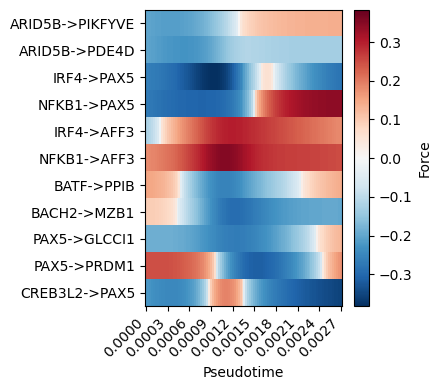

In [70]:
row_scaling = {
    ('NFKB1', 'AFF3'): 0.4  # Scale this link to 50% of its original values
}

force_df_for_cluster, reg_labels, dtime, fig = plot_force_heatmap_with_clustering(
    force_df=lf_forces_dcurve,
    dtime=dtime,
    regulations=GC_links_plotting,
    cmap='RdBu_r',
    vmax=None,
    figsize= (4.5, 4),
    plot_figure=True,
    perform_clustering=False,
    row_scaling=row_scaling
)
plt.yticks(fontsize=10)
plt.tight_layout()
# plt.savefig('/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/output/figures/enriched_links_GC.pdf', 
#             bbox_inches='tight', 
#             dpi=100,
#             format='pdf')
plt.show()


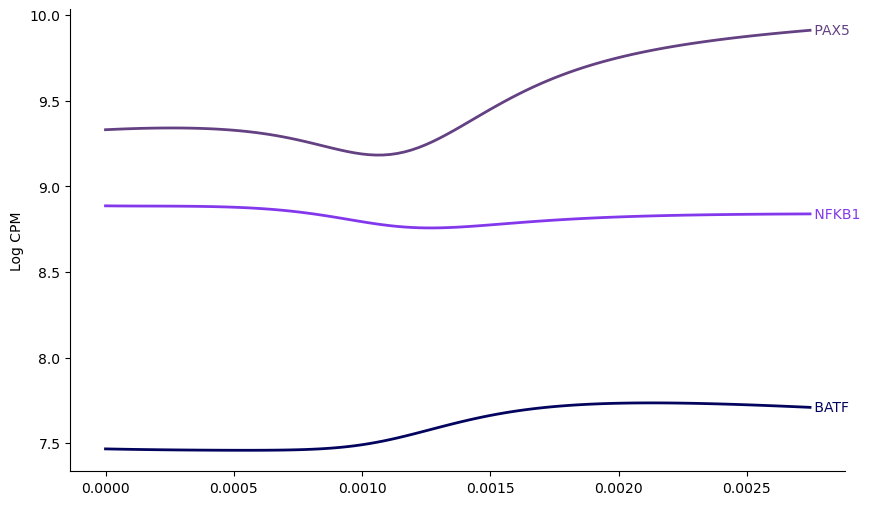

In [22]:
# Plot expression trajectories
fig = plt.figure(figsize=(10, 6))
ax = plt.gca()  # Get current axes

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Highlight specific genes
# genes_1 = ['IRF4', 'CREB3L2', 'PRDM1','BACH2', 'RUNX2', 'XBP1']
# colors_1 = ['#0077b6', '#9d0208', '#f9844a','#644182','#8338ec', '#03045e']

genes_1 = ['IRF4', 'CREB3L2', 'PRDM1']
colors_1 = ['#0077b6', '#9d0208', '#f9844a']
genes_2 = ['PAX5', 'NFKB1', 'BATF']
colors_2 = ['#644182','#8338ec', '#03045e']

for gene, color in zip(genes_2, colors_2):
    if gene in lcpm_dcurve.index:
        line = plt.plot(dtime, lcpm_dcurve.loc[gene], linewidth=2, color=color)
        # Add label at the end of the line
        plt.text(dtime.iloc[-1], lcpm_dcurve.loc[gene].iloc[-1], f' {gene}', 
                color=color, 
                verticalalignment='center')

plt.ylabel('Log CPM')
plt.savefig('/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/output/figures/TF_expression_GC_2nd_wave.pdf', 
            bbox_inches='tight', 
            dpi=100,
            format='pdf')
plt.show()

# Episodic enrichment plots

In [48]:
# enrichment files 
pb_ep1 = "/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/output/intermediate_tmp_files/direct_effect_enrichment/enrichment_ep1_pb.csv"
pb_ep2 = "/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/output/intermediate_tmp_files/direct_effect_enrichment/enrichment_ep2_pb.csv"
pb_ep3 = "/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/output/intermediate_tmp_files/direct_effect_enrichment/enrichment_ep3_pb.csv"
pb_ep4 = "/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/output/intermediate_tmp_files/direct_effect_enrichment/enrichment_ep4_pb.csv"

In [72]:
def sort_tfs_by_gene_similarity(tf_genes_dict, method='jaccard_hierarchical', return_linkage=False):
    """
    Sorts TFs based on gene similarity using Jaccard similarity and hierarchical clustering.
    
    Parameters:
    -----------
    tf_genes_dict : dict
        Dictionary mapping TF names to sets of target genes.
    method : str, default 'jaccard_hierarchical'
        Method for sorting. Currently supports 'jaccard_hierarchical'.
    return_linkage : bool, default False
        Whether to return the linkage matrix along with sorted TFs.
        
    Returns:
    --------
    list or tuple
        If return_linkage=False: List of TF names sorted by gene similarity.
        If return_linkage=True: Tuple of (sorted_tfs, linkage_matrix, tf_labels)
    """
    
    all_tfs = list(tf_genes_dict.keys())
    
    if len(all_tfs) <= 1:
        sorted_tfs = sorted(all_tfs)
        if return_linkage:
            return sorted_tfs, None, all_tfs
        return sorted_tfs
    
    def jaccard_similarity(set1, set2):
        """Calculate Jaccard similarity between two gene sets."""
        if len(set1) == 0 and len(set2) == 0:
            return 1.0  # Both empty, consider similar
        intersection = len(set1.intersection(set2))
        union = len(set1.union(set2))
        return intersection / union if union > 0 else 0.0
    
    # Create similarity matrix
    n_tfs = len(all_tfs)
    similarity_matrix = np.zeros((n_tfs, n_tfs))
    
    for i, tf1 in enumerate(all_tfs):
        for j, tf2 in enumerate(all_tfs):
            similarity_matrix[i, j] = jaccard_similarity(tf_genes_dict[tf1], tf_genes_dict[tf2])
    
    # Convert to distance matrix (1 - similarity) for clustering
    distance_matrix = 1 - similarity_matrix
    
    try:
        # Convert to condensed distance matrix for linkage
        from scipy.spatial.distance import squareform
        condensed_dist = squareform(distance_matrix)
        linkage_matrix = linkage(condensed_dist, method='ward')
        
        # Get the order of TFs from clustering
        cluster_order = leaves_list(linkage_matrix)
        sorted_tfs = [all_tfs[i] for i in cluster_order]
        
        if return_linkage:
            return sorted_tfs, linkage_matrix, all_tfs
        
    except Exception as e:
        # Fallback to alphabetical sorting if clustering fails
        print(f"Warning: Gene similarity clustering failed ({e}), using alphabetical sorting")
        sorted_tfs = sorted(all_tfs)
        if return_linkage:
            return sorted_tfs, None, all_tfs
    
    return sorted_tfs


def plot_tf_episodic_enrichment_dotplot(
    df_ep1, df_ep2, df_ep3, df_ep4,
    episode_labels=['Episode 1', 'Episode 2', 'Episode 3', 'Episode 4'],
    figsize=(12, 8),
    min_dot_size=10,
    max_dot_size=300,
    p_value_threshold=0.05,
    cmap_name="coolwarm",
    value_legend_title="Enrichment Score",
    size_legend_title="P-value",
    sort_by_gene_similarity=False,
    show_dendrogram=False,
    dendrogram_ratio=0.2,
    show_plot=True
):
    """
    Plots a dotplot for TF episodic enrichment where dot color represents enrichment score 
    and dot size represents p-value significance (smaller p-value = larger dot).
    TFs are sorted alphabetically by default, or by gene similarity if specified.
    
    Parameters:
    -----------
    df_ep1, df_ep2, df_ep3, df_ep4 : pd.DataFrame
        DataFrames for each episode containing columns: TF, p_value, enrichment_score, genes_in_lf, etc.
    episode_labels : list, default ['Episode 1', 'Episode 2', 'Episode 3', 'Episode 4']
        Labels for the episodes to display on x-axis.
    figsize : tuple, default (12, 8)
        Figure size.
    min_dot_size : int, default 10
        Minimum size for dots (for p-values > threshold).
    max_dot_size : int, default 300
        Maximum size for dots (for smallest p-values).
    p_value_threshold : float, default 0.05
        P-value threshold above which dots get minimum size.
    cmap_name : str, default "coolwarm"
        Colormap for the enrichment scores.
    value_legend_title : str, default "Enrichment Score"
        Title for the colorbar.
    size_legend_title : str, default "P-value"
        Title for the size legend.
    sort_by_gene_similarity : bool, default False
        If True, sorts TFs by gene similarity using Jaccard similarity and hierarchical clustering.
        If False, sorts TFs alphabetically.
    show_dendrogram : bool, default False
        If True and sort_by_gene_similarity=True, shows a dendrogram of TF clustering.
    dendrogram_ratio : float, default 0.2
        Ratio of figure width to use for dendrogram (when show_dendrogram=True).
    show_plot : bool, default True
        Whether to display the plot.
        
    Returns:
    --------
    matplotlib.figure.Figure or None
        The generated figure object, or None if plotting fails.
    pd.DataFrame or None
        Combined plotting dataframe, or None if preparation fails.
    """    
    # 1. Input validation
    dfs = [df_ep1, df_ep2, df_ep3, df_ep4]
    required_cols = ['TF', 'p_value', 'enrichment_score', 'genes_in_lf']
    
    for i, df in enumerate(dfs):
        if df is None or df.empty:
            print(f"Episode {i+1} dataframe is None or empty.")
            return None, None
        for col in required_cols:
            if col not in df.columns:
                print(f"Episode {i+1} dataframe missing required column: {col}")
                return None, None
    
    # 2. Helper function to parse genes_in_lf column
    def parse_genes_in_lf(genes_str):
        """Parse the string representation of genes tuple."""
        try:
            if pd.isna(genes_str) or genes_str == '' or genes_str == '()':
                return set()
            # Handle string representation of tuples
            genes_tuple = ast.literal_eval(genes_str)
            if isinstance(genes_tuple, tuple):
                return set(genes_tuple)
            elif isinstance(genes_tuple, str):
                return {genes_tuple}
            else:
                return set()
        except:
            return set()
    
    # 3. Collect all TFs and their associated genes across all episodes
    tf_genes_dict = {}  # TF -> set of genes across all episodes
    plot_data_list = []
    
    for i, (df, episode_label) in enumerate(zip(dfs, episode_labels)):
        df_clean = df.dropna(subset=['TF', 'p_value', 'enrichment_score'])
        
        for _, row in df_clean.iterrows():
            tf_name = row['TF']
            genes_set = parse_genes_in_lf(row.get('genes_in_lf', ''))
            
            # Accumulate genes for each TF across episodes
            if tf_name not in tf_genes_dict:
                tf_genes_dict[tf_name] = set()
            tf_genes_dict[tf_name].update(genes_set)
            
            plot_data_list.append({
                'episode': episode_label,
                'episode_idx': i,
                'TF': tf_name,
                'p_value': row['p_value'],
                'enrichment_score': row['enrichment_score']
            })
    
    if not plot_data_list:
        print("No valid data found across all episodes.")
        return None, None
    
    plot_data_df = pd.DataFrame(plot_data_list)
    
    # 4. Sort TFs based on specified method
    if sort_by_gene_similarity:
        if show_dendrogram:
            all_tfs_sorted, linkage_matrix, original_tf_labels = sort_tfs_by_gene_similarity(
                tf_genes_dict, return_linkage=True)
        else:
            all_tfs_sorted = sort_tfs_by_gene_similarity(tf_genes_dict)
            linkage_matrix = None
            original_tf_labels = None
    else:
        all_tfs_sorted = sorted(tf_genes_dict.keys())
        linkage_matrix = None
        original_tf_labels = None
    
    # 5. Map p-values to dot sizes (updated using Scanpy-like logic)
    def p_value_to_size(p_val):
        if p_val > p_value_threshold:
            return min_dot_size * 0.5  # Smaller dot for non-significant
        # Scale significant p-values
        min_p_cap = 1e-6  # Prevents -log10(0)
        log_p = -np.log10(max(p_val, min_p_cap))
        log_thresh = -np.log10(p_value_threshold)
        log_min_cap = -np.log10(min_p_cap)
        
        if log_min_cap == log_thresh:
            scaled_val = 1.0  # Avoid div-by-zero
        else:
            scaled_val = (log_p - log_thresh) / (log_min_cap - log_thresh)
        
        size = min_dot_size + (max_dot_size - min_dot_size) * min(scaled_val, 1.0)
        return size

    plot_data_df['dot_size'] = plot_data_df['p_value'].apply(p_value_to_size)

    
    # 6. Create coordinate mappings
    episode_x_coords = {label: i for i, label in enumerate(episode_labels)}
    tf_y_coords = {tf: i for i, tf in enumerate(all_tfs_sorted)}
    
    # 7. Create figure with subplots
    if show_dendrogram and linkage_matrix is not None and sort_by_gene_similarity:
        # Create figure with dendrogram and main plot
        fig = plt.figure(figsize=figsize)
        
        # Calculate subplot widths
        dendro_width = dendrogram_ratio
        main_width = 1 - dendrogram_ratio - 0.15  # Leave space for colorbar
        
        # Create subplots
        ax_dendro = fig.add_subplot(1, 2, 1)
        ax_main = fig.add_subplot(1, 2, 2)
        
        # Adjust subplot positions
        dendro_left = 0.05
        main_left = dendro_left + dendro_width + 0.02
        
        ax_dendro.set_position([dendro_left, 0.1, dendro_width, 0.8])
        ax_main.set_position([main_left, 0.1, main_width, 0.8])
        
        # Plot dendrogram
        from scipy.cluster.hierarchy import dendrogram
        dendro_plot = dendrogram(
            linkage_matrix, 
            ax=ax_dendro,
            orientation='left',
            labels=original_tf_labels,
            leaf_font_size=8,
            color_threshold=0.7*max(linkage_matrix[:,2])
        )
        ax_dendro.invert_yaxis()
        ax_dendro.set_ylabel("TF Clustering")
        ax_dendro.set_xlabel("Distance")
        ax_dendro.spines['top'].set_visible(False)
        ax_dendro.spines['right'].set_visible(False)
        
        # Remove x-axis labels for cleaner look
        ax_dendro.tick_params(axis='y', which='both', left=False, labelleft=False)
        
    else:
        # Standard single plot
        fig, ax_main = plt.subplots(figsize=figsize)
    
    # 8. Create scatter plot
    scatter = ax_main.scatter(
        x=plot_data_df['episode'].map(episode_x_coords),
        y=plot_data_df['TF'].map(tf_y_coords),
        s=plot_data_df['dot_size'],
        c=plot_data_df['enrichment_score'],
        cmap=cmap_name,
        edgecolors='gray',
        linewidths=0.5,
        alpha=0.8
    )
    
    # 9. Axis formatting
    # X-axis (Episodes)
    ax_main.set_xticks(list(episode_x_coords.values()))
    ax_main.set_xticklabels(episode_labels, rotation=0, ha="center")
    # Add horizontal padding to main plot
    x_pad = 0.5  # tweak this to get desired spacing
    ax_main.set_xlim(-x_pad, len(episode_labels) - 1 + x_pad)

    ax_main.set_xlabel("Episode")
    
    # Y-axis (TFs)
    ax_main.set_yticks(list(tf_y_coords.values()))
    ax_main.set_yticklabels(all_tfs_sorted)
    ax_main.set_ylabel("Transcription Factor")
    
    # 10. Colorbar for Enrichment Score
    if show_dendrogram and linkage_matrix is not None and sort_by_gene_similarity:
        cbar = fig.colorbar(scatter, ax=ax_main, fraction=0.046, pad=0.04)
    else:
        cbar = fig.colorbar(scatter, ax=ax_main, fraction=0.03, pad=0.15)
    cbar.set_label(value_legend_title)
    
    # 11. Size legend for P-values
    # Create representative p-values for the legend
    legend_p_values = [0.001, 0.01, 0.05, 0.1]
    legend_dots = []
    
    for p_val in legend_p_values:
        size_val = p_value_to_size(p_val)
        if p_val > p_value_threshold:
            label_text = f"p > {p_value_threshold}"
        else:
            label_text = f"p = {p_val}"
        legend_dots.append(plt.scatter([], [], s=size_val, c='gray', label=label_text))
    
    # Position the size legend
    if show_dendrogram and linkage_matrix is not None and sort_by_gene_similarity:
        bbox_anchor = (1.25, 0.4)
    else:
        bbox_anchor = (1.18, 0.4)
        
    size_leg = ax_main.legend(
        handles=legend_dots, 
        title=size_legend_title,
        bbox_to_anchor=bbox_anchor, 
        loc='center left',
        labelspacing=1.5, 
        borderpad=1, 
        frameon=True,
        handletextpad=1.5,
        scatterpoints=1
    )
    
    # 12. Final formatting
    sorting_method = "gene similarity" if sort_by_gene_similarity else "alphabetical" 
    ax_main.grid(True, linestyle='--', alpha=0.3, axis='both')
    ax_main.tick_params(axis='both', which='major', pad=5)
    
    # Invert y-axis so first TF is at top
    ax_main.invert_yaxis()
    
    if show_plot:
        plt.tight_layout()
        plt.show()
    
    return fig, plot_data_df

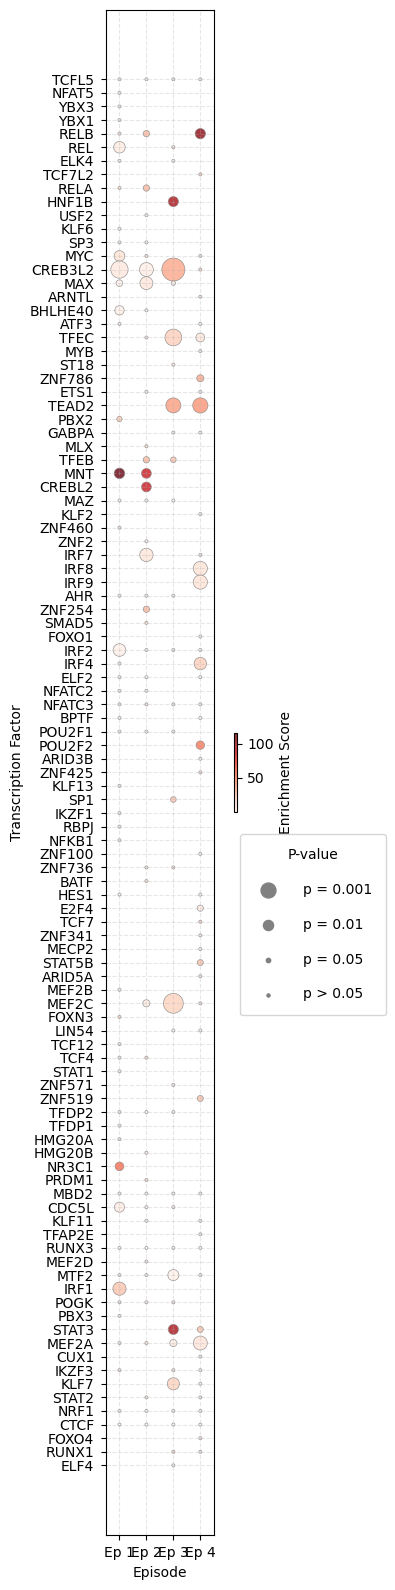

In [74]:
df_ep1 = pd.read_csv(pb_ep1)
df_ep2 = pd.read_csv(pb_ep2)
df_ep3 = pd.read_csv(pb_ep3)
df_ep4 = pd.read_csv(pb_ep4)

fig, plot_data = plot_tf_episodic_enrichment_dotplot(
    df_ep1, df_ep2, df_ep3, df_ep4,
    episode_labels=['Ep 1', 'Ep 2', 'Ep 3', 'Ep 4'],
    figsize=(4, 16),
    p_value_threshold=0.05,
    cmap_name="Reds",
    sort_by_gene_similarity=True,
    show_dendrogram=False
)
# save the plot
fig.savefig(os.path.join(output_folder, "tf_episodic_enrichment_PB.png"), dpi=300)

### Showing the downstream programs regulated by the enriched TFs inside the LF

In [89]:
def plot_tf_gene_coregulation_heatmap(
    df_ep1, df_ep2, df_ep3, df_ep4,
    episode_labels=['Ep 1', 'Ep 2', 'Ep 3', 'Ep 4'],
    min_tf_episodes=1,  # Minimum episodes a TF must appear in to be included
    min_gene_tfs=1,     # Minimum TFs a gene must be regulated by to be included
    figsize=None,
    cmap_name="Blues",
    cluster_genes=True,
    cluster_tfs=True,
    show_values=True,
    value_fontsize=8,
    show_plot=True
):
    """
    Creates a heatmap showing TF-gene co-regulation patterns across episodes.
    
    Parameters:
    -----------
    df_ep1, df_ep2, df_ep3, df_ep4 : pd.DataFrame
        Episode dataframes with columns: TF, genes_in_lf, etc.
    min_tf_episodes : int
        Minimum number of episodes a TF must appear in to be included
    min_gene_tfs : int  
        Minimum number of TFs that must regulate a gene for it to be included
    cluster_genes : bool
        Whether to cluster genes by co-regulation similarity
    cluster_tfs : bool
        Whether to cluster TFs by target gene similarity
    """
    
    # Helper function to parse genes
    def parse_genes_in_lf(genes_str):
        try:
            if pd.isna(genes_str) or genes_str == '' or genes_str == '()':
                return set()
            genes_tuple = ast.literal_eval(genes_str)
            return set(genes_tuple) if isinstance(genes_tuple, tuple) else {genes_tuple} if isinstance(genes_tuple, str) else set()
        except:
            return set()
    
    # Collect TF-gene relationships across all episodes
    tf_gene_episodes = {}  # (tf, gene) -> set of episodes
    
    dfs = [df_ep1, df_ep2, df_ep3, df_ep4]
    for ep_idx, (df_ep, ep_label) in enumerate(zip(dfs, episode_labels)):
        if df_ep is None or df_ep.empty:
            continue
            
        df_clean = df_ep.dropna(subset=['TF', 'genes_in_lf'])
        
        for _, row in df_clean.iterrows():
            tf_name = row['TF']
            genes_set = parse_genes_in_lf(row.get('genes_in_lf', ''))
            
            for gene in genes_set:
                key = (tf_name, gene)
                if key not in tf_gene_episodes:
                    tf_gene_episodes[key] = set()
                tf_gene_episodes[key].add(ep_idx)
    
    if not tf_gene_episodes:
        print("No TF-gene relationships found.")
        return None, None
    
    # Filter TFs and genes based on minimum criteria
    tf_episode_counts = {}
    gene_tf_counts = {}
    
    for (tf, gene), episodes in tf_gene_episodes.items():
        # Count episodes per TF
        if tf not in tf_episode_counts:
            tf_episode_counts[tf] = set()
        tf_episode_counts[tf].update(episodes)
        
        # Count TFs per gene
        if gene not in gene_tf_counts:
            gene_tf_counts[gene] = set()
        gene_tf_counts[gene].add(tf)
    
    # Filter TFs and genes
    selected_tfs = [tf for tf, episodes in tf_episode_counts.items() 
                   if len(episodes) >= min_tf_episodes]
    selected_genes = [gene for gene, tfs in gene_tf_counts.items() 
                     if len(tfs) >= min_gene_tfs]
    
    if not selected_tfs or not selected_genes:
        print(f"No TFs or genes meet the filtering criteria (min_tf_episodes={min_tf_episodes}, min_gene_tfs={min_gene_tfs})")
        return None, None
    
    # Create TF-gene matrix with episode counts
    tf_gene_matrix = np.zeros((len(selected_tfs), len(selected_genes)))
    
    for i, tf in enumerate(selected_tfs):
        for j, gene in enumerate(selected_genes):
            key = (tf, gene)
            if key in tf_gene_episodes:
                tf_gene_matrix[i, j] = len(tf_gene_episodes[key])
    
    # Alternative clustering using cosine similarity:
    if cluster_tfs and len(selected_tfs) > 1:
        from sklearn.metrics.pairwise import cosine_distances
        
        try:
            # Use cosine distance for clustering
            tf_distances = cosine_distances(tf_gene_matrix)
            tf_condensed = squareform(tf_distances)
            tf_linkage = linkage(tf_condensed, method='ward')
            tf_order = leaves_list(tf_linkage)
            selected_tfs = [selected_tfs[i] for i in tf_order]
            tf_gene_matrix = tf_gene_matrix[tf_order, :]
        except Exception as e:
            print(f"TF clustering failed: {e}")

    if cluster_genes and len(selected_genes) > 1:
        try:
            gene_tf_matrix = tf_gene_matrix.T  
            gene_distances = cosine_distances(gene_tf_matrix)
            gene_condensed = squareform(gene_distances)
            gene_linkage = linkage(gene_condensed, method='ward')
            gene_order = leaves_list(gene_linkage)
            selected_genes = [selected_genes[i] for i in gene_order]
            tf_gene_matrix = tf_gene_matrix[:, gene_order]
        except Exception as e:
            print(f"Gene clustering failed: {e}")
    
    # Create heatmap
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot heatmap
    im = ax.imshow(tf_gene_matrix, cmap=cmap_name, aspect='auto', 
                   vmin=0, vmax=len(episode_labels))
    
    # Set ticks and labels
    ax.set_xticks(range(len(selected_genes)))
    ax.set_xticklabels(selected_genes, rotation=90, ha='center', fontsize=8)
    ax.set_xlabel("Target Genes", fontsize=10)
    
    ax.set_yticks(range(len(selected_tfs)))
    ax.set_yticklabels(selected_tfs, fontsize=8)
    ax.set_ylabel("Transcription Factors", fontsize=10)
    
    # Add values to cells if requested
    if show_values:
        for i in range(len(selected_tfs)):
            for j in range(len(selected_genes)):
                value = tf_gene_matrix[i, j]
                if value > 0:
                    text_color = 'white' if value > len(episode_labels)/2 else 'black'
                    ax.text(j, i, f'{int(value)}', ha='center', va='center',
                           color=text_color, fontsize=value_fontsize)
    
    # Colorbar
    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('Number of Episodes', fontsize=10)
    cbar.set_ticks(range(len(episode_labels) + 1))
    
    # Title
    ax.set_title(f'TF-Gene Co-regulation Across Episodes\n({len(selected_tfs)} TFs, {len(selected_genes)} genes)', 
                fontsize=12, pad=20)
    
    # Grid
    ax.grid(True, linestyle='-', alpha=0.3, linewidth=0.5)
    ax.set_xlim(-0.5, len(selected_genes) - 0.5)
    ax.set_ylim(-0.5, len(selected_tfs) - 0.5)
    
    plt.tight_layout()
    
    if show_plot:
        plt.show()
    
    # Return summary dataframe
    summary_data = []
    for i, tf in enumerate(selected_tfs):
        for j, gene in enumerate(selected_genes):
            episodes_count = tf_gene_matrix[i, j]
            if episodes_count > 0:
                summary_data.append({
                    'TF': tf,
                    'Gene': gene, 
                    'Episodes_Count': int(episodes_count)
                })
    
    summary_df = pd.DataFrame(summary_data)
    
    return fig, summary_df, selected_tfs, selected_genes

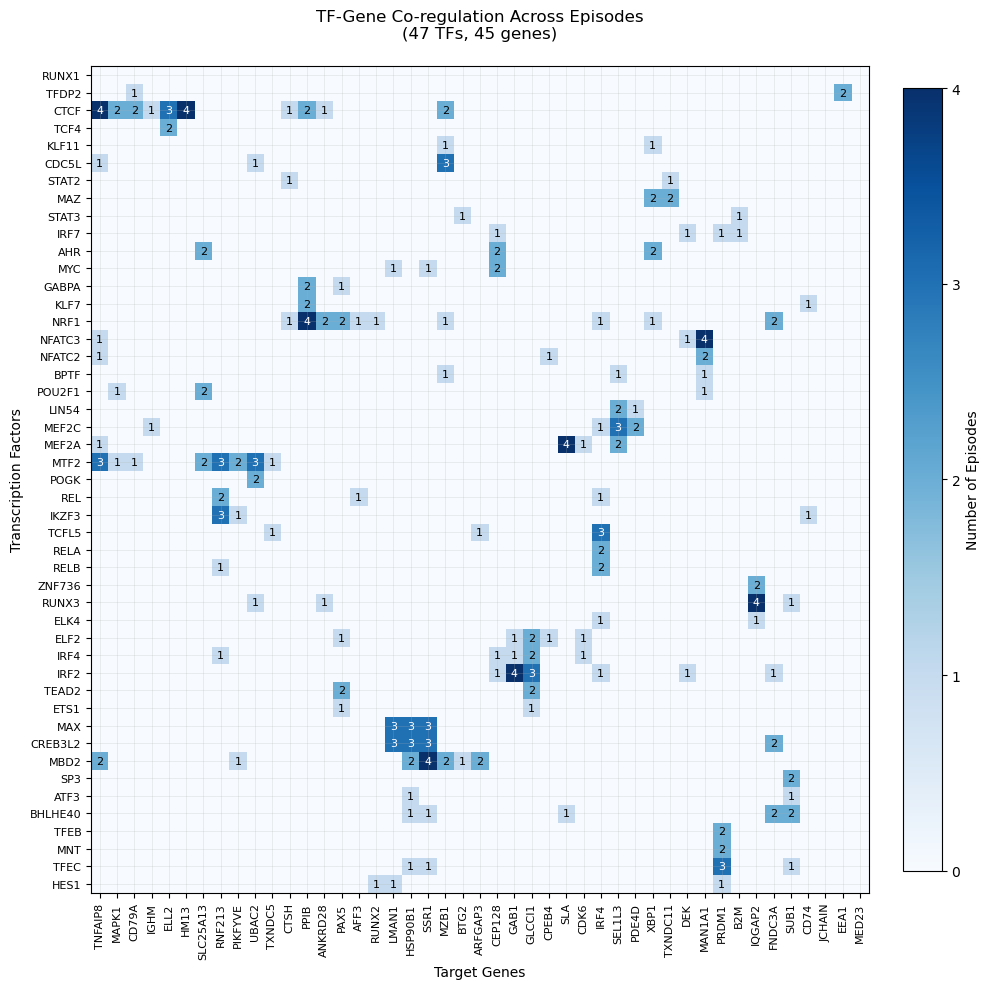

In [90]:
fig, summary_df, selected_tfs, selected_genes = plot_tf_gene_coregulation_heatmap(
    df_ep1, df_ep2, df_ep3, df_ep4,
    figsize=(10, 10),
    min_tf_episodes=2,  # TF must appear in at least 2 episodes
    min_gene_tfs=2,     # Gene must be regulated by at least 2 TFs
    cluster_genes=True,
    cluster_tfs=True,
    show_values=True
)